### Generating Data

Below we choose 100 different starting points for the Lorenz system and calculate the trajectory for 8 seconds in time. We will use this to train our neural network. This will allow the network to act as a time-stepper : given a point (x,y,z) it can calculate the new point (x', y', z') dt seconds further in time.

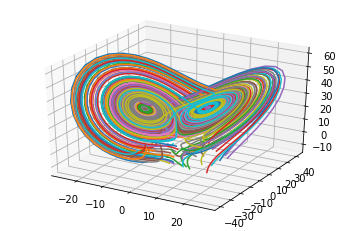

In [147]:
'''

lorenz_net.py

This code will train a feedforward neural network to predict trajectories within the lorenz system.

'''

import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D


dt = 0.01  # time step size
T = 8  # total simulation time per initial condition
t = np.arange(start=0, stop=T, step=dt)
num_trajectories = 100  # number of trajectories to simulate

# Set parameters of the lorenz system (rho set later)
b = 8/3
sig = 10


def lorenz(t, x, rho):
    global b, sig
    return [sig * (x[1] - x[0]),  rho * x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]


for i, rho in enumerate([28]): # 10, 28, 40
    fig = plt.figure(i)
    ax = fig.gca(projection='3d')
    for j in range(num_trajectories):
        x0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

        # Pass in initial conditions and relative/absolute tolerance
        y_vals = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=x0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

        if j == 0 and i == 0:
            inputs = y_vals[:-1, :]
            outputs = y_vals[1:, :]
        else:
            inputs = np.vstack((inputs, y_vals[:-1, :]))
            outputs = np.vstack((outputs, y_vals[1:, :]))

        ax.plot(xs=y_vals[:, 0], ys=y_vals[:, 1], zs=y_vals[:, 2])


    plt.show(block=True)


# Inputs stores the (x,y,z) at each time t and Outputs stores the (x,y,z) at each time (t+1) ; the two are just staggered


### Training A neural Network

Here we define a standard 3-layer feedforward neural network with 20 neurons in each layer

In [148]:
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(20, activation='sigmoid', input_shape = (3,)))
model.add(Dense(40, activation='sigmoid'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='linear'))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='adadelta', loss='mean_squared_error')

In [149]:
model.fit(inputs, outputs, 
         epochs=2000,
         batch_size=500,
         shuffle=True, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Train on 63920 samples, validate on 15980 samples
Epoch 1/2000
63920/63920 [==============================] - 1s 20us/step - loss: 67.7884 - val_loss: 33.6748
Epoch 2/2000
63920/63920 [==============================] - 0s 4us/step - loss: 16.0122 - val_loss: 13.8205
Epoch 3/2000
63920/63920 [==============================] - 0s 4us/step - loss: 11.5016 - val_loss: 11.9504
Epoch 4/2000
63920/63920 [==============================] - 0s 4us/step - loss: 9.4485 - val_loss: 11.5895
Epoch 5/2000
63920/63920 [==============================] - 0s 4us/step - loss: 7.7219 - val_loss: 7.0256
Epoch 6/2000
63920/63920 [==============================] - 0s 5us/step - loss: 6.4157 - val_loss: 5.5666
Epoch 7/2000
63920/63920 [==============================] - 0s 5us/step - loss: 5.0559 - val_loss: 4.3252
Epoch 8/2000
63920/63920 [==============================] - 0s 5us/step - loss: 4.0239 - val_loss: 4.7137
Epoch 9/2000
63920/63920 [==============================] - 0s 5us/step - loss: 3.3603 - val_l

63920/63920 [==============================] - 0s 4us/step - loss: 0.3710 - val_loss: 0.4030
Epoch 78/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3565 - val_loss: 0.4021
Epoch 79/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3689 - val_loss: 0.4212
Epoch 80/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3489 - val_loss: 0.3684
Epoch 81/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3690 - val_loss: 0.4634
Epoch 82/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3683 - val_loss: 0.3845
Epoch 83/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3741 - val_loss: 0.4606
Epoch 84/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.3861 - val_loss: 0.5182
Epoch 85/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.3605 - val_loss: 0.4243
Epoch 86/2000
63920/63920 [========================

63920/63920 [==============================] - 0s 4us/step - loss: 0.2600 - val_loss: 0.2702
Epoch 154/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.2739 - val_loss: 0.2233
Epoch 155/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2408 - val_loss: 0.3045
Epoch 156/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2200 - val_loss: 0.2449
Epoch 157/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.2469 - val_loss: 0.2134
Epoch 158/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2544 - val_loss: 0.3322
Epoch 159/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2558 - val_loss: 0.2173
Epoch 160/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2441 - val_loss: 0.2400
Epoch 161/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2692 - val_loss: 0.3252
Epoch 162/2000
63920/63920 [===============

Epoch 229/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1763 - val_loss: 0.2501
Epoch 230/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2084 - val_loss: 0.1717
Epoch 231/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2255 - val_loss: 0.2069
Epoch 232/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2118 - val_loss: 0.1452
Epoch 233/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2135 - val_loss: 0.2097
Epoch 234/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1988 - val_loss: 0.2495
Epoch 235/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.2633 - val_loss: 0.2933
Epoch 236/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.2321 - val_loss: 0.2870
Epoch 237/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.2504 - val_loss: 0.3179
Epoch 238/2000
63920/63920 [

Epoch 305/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1629 - val_loss: 0.1059
Epoch 306/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1690 - val_loss: 0.1539
Epoch 307/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1793 - val_loss: 0.1470
Epoch 308/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1984 - val_loss: 0.2167
Epoch 309/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1769 - val_loss: 0.1966
Epoch 310/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1730 - val_loss: 0.1575
Epoch 311/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1770 - val_loss: 0.2101
Epoch 312/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1643 - val_loss: 0.1000
Epoch 313/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1219 - val_loss: 0.1342
Epoch 314/2000
63920/63920 [

Epoch 381/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1858 - val_loss: 0.1441
Epoch 382/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1650 - val_loss: 0.1746
Epoch 383/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1499 - val_loss: 0.0769
Epoch 384/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1392 - val_loss: 0.1521
Epoch 385/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1535 - val_loss: 0.1867
Epoch 386/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1576 - val_loss: 0.1469
Epoch 387/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1767 - val_loss: 0.2092
Epoch 388/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1486 - val_loss: 0.1227
Epoch 389/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1390 - val_loss: 0.1581
Epoch 390/2000
63920/63920 [

Epoch 457/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1224 - val_loss: 0.1829
Epoch 458/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1350 - val_loss: 0.1714
Epoch 459/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1259 - val_loss: 0.0840
Epoch 460/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1115 - val_loss: 0.1644
Epoch 461/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1615 - val_loss: 0.1832
Epoch 462/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1462 - val_loss: 0.2234
Epoch 463/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1357 - val_loss: 0.1245
Epoch 464/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1441 - val_loss: 0.1336
Epoch 465/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1342 - val_loss: 0.0932
Epoch 466/2000
63920/63920 [

Epoch 533/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1415 - val_loss: 0.1600
Epoch 534/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1312 - val_loss: 0.1448
Epoch 535/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1118 - val_loss: 0.1827
Epoch 536/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1196 - val_loss: 0.1149
Epoch 537/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1201 - val_loss: 0.0987
Epoch 538/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1066 - val_loss: 0.0719
Epoch 539/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1335 - val_loss: 0.1036
Epoch 540/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1090 - val_loss: 0.0969
Epoch 541/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1081 - val_loss: 0.1216
Epoch 542/2000
63920/63920 [

Epoch 609/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1112 - val_loss: 0.1227
Epoch 610/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1200 - val_loss: 0.1016
Epoch 611/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1372 - val_loss: 0.1295
Epoch 612/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1109 - val_loss: 0.0762
Epoch 613/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0898 - val_loss: 0.1229
Epoch 614/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1094 - val_loss: 0.1004
Epoch 615/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0973 - val_loss: 0.0863
Epoch 616/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1149 - val_loss: 0.1253
Epoch 617/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1255 - val_loss: 0.1190
Epoch 618/2000
63920/63920 [

Epoch 685/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1281 - val_loss: 0.1334
Epoch 686/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1117 - val_loss: 0.0983
Epoch 687/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0914 - val_loss: 0.0767
Epoch 688/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0995 - val_loss: 0.1231
Epoch 689/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1104 - val_loss: 0.1329
Epoch 690/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0997 - val_loss: 0.0694
Epoch 691/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0907 - val_loss: 0.1264
Epoch 692/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1023 - val_loss: 0.1531
Epoch 693/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1232 - val_loss: 0.1122
Epoch 694/2000
63920/63920 [

Epoch 761/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1056 - val_loss: 0.0388
Epoch 762/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0602 - val_loss: 0.1001
Epoch 763/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0926 - val_loss: 0.0707
Epoch 764/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0900 - val_loss: 0.1217
Epoch 765/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.1028 - val_loss: 0.1209
Epoch 766/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0986 - val_loss: 0.1278
Epoch 767/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0995 - val_loss: 0.0813
Epoch 768/2000
63920/63920 [==============================] - 0s 6us/step - loss: 0.0989 - val_loss: 0.1260
Epoch 769/2000
63920/63920 [==============================] - 0s 6us/step - loss: 0.0941 - val_loss: 0.1218
Epoch 770/2000
63920/63920 [

Epoch 837/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0972 - val_loss: 0.0546
Epoch 838/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0889 - val_loss: 0.0869
Epoch 839/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0863 - val_loss: 0.0757
Epoch 840/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0772 - val_loss: 0.0977
Epoch 841/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0672 - val_loss: 0.0810
Epoch 842/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0910 - val_loss: 0.1037
Epoch 843/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.1003 - val_loss: 0.0968
Epoch 844/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0863 - val_loss: 0.0604
Epoch 845/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0862 - val_loss: 0.0997
Epoch 846/2000
63920/63920 [

Epoch 913/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0668 - val_loss: 0.0684
Epoch 914/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0758 - val_loss: 0.0930
Epoch 915/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0721 - val_loss: 0.0426
Epoch 916/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0671 - val_loss: 0.0917
Epoch 917/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0892 - val_loss: 0.0812
Epoch 918/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0688 - val_loss: 0.0521
Epoch 919/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0867 - val_loss: 0.0833
Epoch 920/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0707 - val_loss: 0.0474
Epoch 921/2000
63920/63920 [==============================] - 0s 6us/step - loss: 0.0608 - val_loss: 0.0745
Epoch 922/2000
63920/63920 [

Epoch 989/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0702 - val_loss: 0.1062
Epoch 990/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0762 - val_loss: 0.0654
Epoch 991/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0768 - val_loss: 0.0843
Epoch 992/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0729 - val_loss: 0.0425
Epoch 993/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0690 - val_loss: 0.0891
Epoch 994/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0707 - val_loss: 0.0604
Epoch 995/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0690 - val_loss: 0.0896
Epoch 996/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0663 - val_loss: 0.0537
Epoch 997/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0657 - val_loss: 0.0799
Epoch 998/2000
63920/63920 [

63920/63920 [==============================] - 0s 5us/step - loss: 0.0560 - val_loss: 0.0751
Epoch 1065/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0742 - val_loss: 0.0755
Epoch 1066/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0660 - val_loss: 0.0499
Epoch 1067/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0664 - val_loss: 0.0766
Epoch 1068/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0704 - val_loss: 0.0915
Epoch 1069/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0697 - val_loss: 0.1206
Epoch 1070/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0737 - val_loss: 0.0545
Epoch 1071/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0620 - val_loss: 0.0521
Epoch 1072/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0778 - val_loss: 0.0835
Epoch 1073/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0535 - val_loss: 0.0765
Epoch 1140/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0618 - val_loss: 0.0741
Epoch 1141/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0688 - val_loss: 0.0977
Epoch 1142/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0610 - val_loss: 0.0490
Epoch 1143/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0727 - val_loss: 0.0509
Epoch 1144/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0544 - val_loss: 0.0651
Epoch 1145/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0679 - val_loss: 0.0903
Epoch 1146/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0715 - val_loss: 0.0864
Epoch 1147/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0679 - val_loss: 0.0562
Epoch 1148/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0556 - val_loss: 0.0526
Epoch 1215/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0601 - val_loss: 0.0548
Epoch 1216/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0479 - val_loss: 0.0465
Epoch 1217/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0588 - val_loss: 0.0909
Epoch 1218/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0600 - val_loss: 0.0574
Epoch 1219/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0634 - val_loss: 0.0573
Epoch 1220/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0605 - val_loss: 0.0990
Epoch 1221/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0656 - val_loss: 0.0486
Epoch 1222/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0681 - val_loss: 0.0546
Epoch 1223/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0635 - val_loss: 0.0524
Epoch 1290/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0725 - val_loss: 0.0852
Epoch 1291/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0628 - val_loss: 0.0648
Epoch 1292/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0580 - val_loss: 0.0726
Epoch 1293/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0554 - val_loss: 0.0655
Epoch 1294/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0617 - val_loss: 0.0592
Epoch 1295/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0577 - val_loss: 0.0656
Epoch 1296/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0611 - val_loss: 0.1029
Epoch 1297/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0671 - val_loss: 0.0843
Epoch 1298/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0504 - val_loss: 0.0521
Epoch 1365/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0518 - val_loss: 0.0381
Epoch 1366/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0481 - val_loss: 0.0655
Epoch 1367/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0577 - val_loss: 0.0412
Epoch 1368/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0578 - val_loss: 0.0638
Epoch 1369/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0656 - val_loss: 0.0528
Epoch 1370/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0565 - val_loss: 0.0770
Epoch 1371/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0564 - val_loss: 0.0453
Epoch 1372/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0517 - val_loss: 0.0827
Epoch 1373/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0566 - val_loss: 0.0885
Epoch 1440/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0572 - val_loss: 0.0557
Epoch 1441/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0609 - val_loss: 0.0619
Epoch 1442/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0641 - val_loss: 0.0564
Epoch 1443/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0538 - val_loss: 0.0757
Epoch 1444/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0611 - val_loss: 0.0801
Epoch 1445/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0435 - val_loss: 0.0541
Epoch 1446/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0585 - val_loss: 0.0507
Epoch 1447/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0499 - val_loss: 0.0419
Epoch 1448/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0487 - val_loss: 0.0743
Epoch 1515/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0574 - val_loss: 0.0392
Epoch 1516/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0561 - val_loss: 0.0974
Epoch 1517/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0651 - val_loss: 0.0386
Epoch 1518/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0575 - val_loss: 0.0459
Epoch 1519/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0623 - val_loss: 0.0902
Epoch 1520/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0594 - val_loss: 0.0533
Epoch 1521/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0528 - val_loss: 0.0578
Epoch 1522/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0493 - val_loss: 0.0627
Epoch 1523/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0582 - val_loss: 0.0735
Epoch 1590/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0589 - val_loss: 0.0604
Epoch 1591/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0509 - val_loss: 0.0550
Epoch 1592/2000
63920/63920 [==============================] - 0s 6us/step - loss: 0.0501 - val_loss: 0.0585
Epoch 1593/2000
63920/63920 [==============================] - 0s 7us/step - loss: 0.0452 - val_loss: 0.0420
Epoch 1594/2000
63920/63920 [==============================] - 0s 7us/step - loss: 0.0503 - val_loss: 0.0486
Epoch 1595/2000
63920/63920 [==============================] - 0s 6us/step - loss: 0.0444 - val_loss: 0.0506
Epoch 1596/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0435 - val_loss: 0.0389
Epoch 1597/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0573 - val_loss: 0.0518
Epoch 1598/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0549 - val_loss: 0.0678
Epoch 1665/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0523 - val_loss: 0.0690
Epoch 1666/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0531 - val_loss: 0.0428
Epoch 1667/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0427 - val_loss: 0.0652
Epoch 1668/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0576 - val_loss: 0.0471
Epoch 1669/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0475 - val_loss: 0.0598
Epoch 1670/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0571 - val_loss: 0.1090
Epoch 1671/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0575 - val_loss: 0.0438
Epoch 1672/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0484 - val_loss: 0.0502
Epoch 1673/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0687 - val_loss: 0.0402
Epoch 1740/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0464 - val_loss: 0.0526
Epoch 1741/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0578 - val_loss: 0.0428
Epoch 1742/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0485 - val_loss: 0.0553
Epoch 1743/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0477 - val_loss: 0.0569
Epoch 1744/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0335
Epoch 1745/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0481 - val_loss: 0.0717
Epoch 1746/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0544 - val_loss: 0.0519
Epoch 1747/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0638 - val_loss: 0.0822
Epoch 1748/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0645 - val_loss: 0.0492
Epoch 1815/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0601 - val_loss: 0.0431
Epoch 1816/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0497 - val_loss: 0.0495
Epoch 1817/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0638 - val_loss: 0.0979
Epoch 1818/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0500 - val_loss: 0.0598
Epoch 1819/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0562 - val_loss: 0.0496
Epoch 1820/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0495 - val_loss: 0.0534
Epoch 1821/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0396 - val_loss: 0.0319
Epoch 1822/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0446 - val_loss: 0.0484
Epoch 1823/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0602 - val_loss: 0.0806
Epoch 1890/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0583 - val_loss: 0.0463
Epoch 1891/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0581 - val_loss: 0.0553
Epoch 1892/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0564 - val_loss: 0.0518
Epoch 1893/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0485 - val_loss: 0.0492
Epoch 1894/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0424 - val_loss: 0.0722
Epoch 1895/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0502 - val_loss: 0.0486
Epoch 1896/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0423 - val_loss: 0.0252
Epoch 1897/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0403 - val_loss: 0.0502
Epoch 1898/2000
63920/63920 [======

63920/63920 [==============================] - 0s 4us/step - loss: 0.0465 - val_loss: 0.0585
Epoch 1965/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0456 - val_loss: 0.0663
Epoch 1966/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0478 - val_loss: 0.0753
Epoch 1967/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0495 - val_loss: 0.0512
Epoch 1968/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0540 - val_loss: 0.0956
Epoch 1969/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0629 - val_loss: 0.0829
Epoch 1970/2000
63920/63920 [==============================] - 0s 5us/step - loss: 0.0617 - val_loss: 0.0454
Epoch 1971/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0388 - val_loss: 0.0324
Epoch 1972/2000
63920/63920 [==============================] - 0s 4us/step - loss: 0.0521 - val_loss: 0.0430
Epoch 1973/2000
63920/63920 [======

### Analyzing Training

Analyze the loss of the neural net (on both the training and validation datasets) as a function of epochs

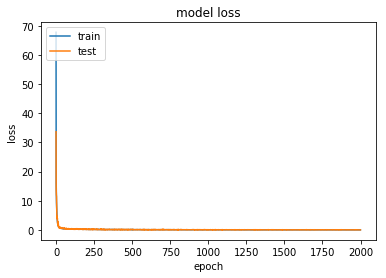

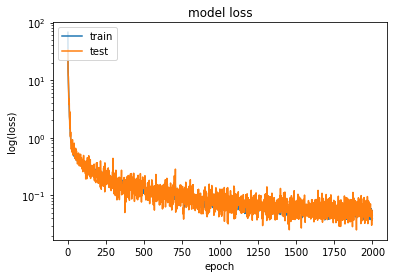

In [150]:
# summarize history for loss
plt.figure(2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(3)
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



### Test Performance of Neural Net

Here, we will generate new trajectories using a random starting condition. Using both an ode solver and our neural network, we will predict the trajectories of the points.

Text(0.5, 0, 'z coord')

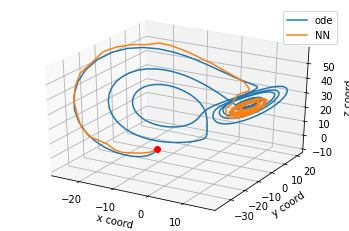

In [177]:
y0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)


rho = 28

y_ode = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=y0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

y_NN = np.zeros(y_ode.shape)
y_NN[0, :] = y0


for i in range(1, y_NN.shape[0]):
    y_NN[i, :] = model.predict(np.expand_dims(y_NN[i-1, :], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')

ax.plot(xs=y_ode[:, 0], ys=y_ode[:, 1], zs=y_ode[:, 2])
ax.plot(xs=y_NN[:, 0], ys=y_NN[:, 1], zs=y_NN[:, 2])
ax.plot([y0[0]], [y0[1]], [y0[2]], 'ro')
ax.legend(['ode', 'NN'])
plt.xlabel('x coord')
plt.ylabel('y coord')
ax.set_zlabel('z coord')

    


In [175]:
#save_me = y0